In [8]:
from os import listdir
from perception import hashers
from sklearn.cluster import KMeans
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

from src.config import DATA_DIR

hasher = hashers.PHashF()
TRAIN_DIR = DATA_DIR / "raw" / "phishIRIS_DL_Dataset/train"

img_to_hash = dict()
hash_to_img = dict()
img_per_company = defaultdict(list)
hash_to_company = defaultdict()

for company in listdir(TRAIN_DIR):
    if company in [".DS_Store", "other"]:
        continue

    for example in listdir(TRAIN_DIR / company):
        file_path = TRAIN_DIR / company / example
        hsh = hasher.compute(str(file_path))
        img_to_hash["-".join(example.split(" "))] = hasher.string_to_vector(hsh)
        hash_to_img[hsh] = "-".join(example.split(" "))
        hash_to_company[hsh] = company
        img_per_company[company].append(hsh)

In [5]:
kmeans = KMeans(init="k-means++", n_init="auto")
clusters = kmeans.fit(list(img_to_hash.values()))
data_transformed = kmeans.transform(list(img_to_hash.values()))

In [ ]:
cluster_to_hash = defaultdict(list)
for idx, (img_name, img_hash) in enumerate(img_to_hash.items()):
    cluster_to_hash[kmeans.labels_[idx]].append(hasher.vector_to_string(img_hash))

for idx in range(clusters.n_clusters):
    labels = []
    for x in cluster_to_hash[idx]:
        labels.append(hash_to_company[x])
    unique_labels, label_counts = np.unique(labels, return_counts=True)

    # Create a bar plot for the labels of this company
    plt.figure(figsize=(15, 5))
    plt.bar(unique_labels, label_counts, color="pink")
    plt.xlabel("Labels")
    plt.ylabel("Count of Images")
    plt.title(f"Label Distribution for cluster #{idx}")
    plt.xticks(unique_labels)
    plt.show()

    print(f"Cluster #{idx} Labels: ", dict(zip(unique_labels, label_counts)))
    print("=" * 10)

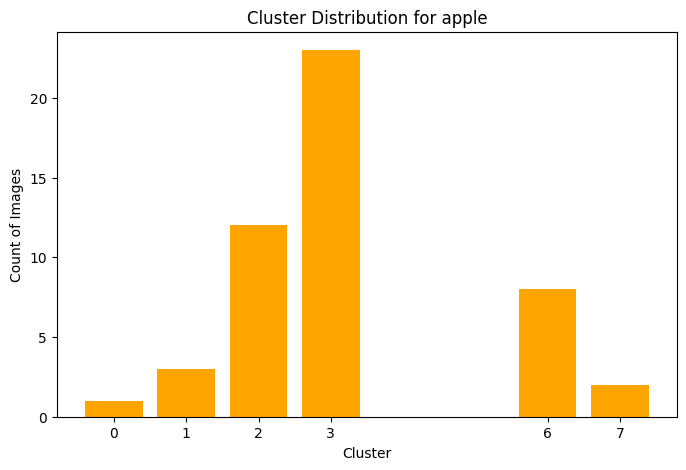

apple:  {0.0: 1, 1.0: 3, 2.0: 12, 3.0: 23, 6.0: 8, 7.0: 2}


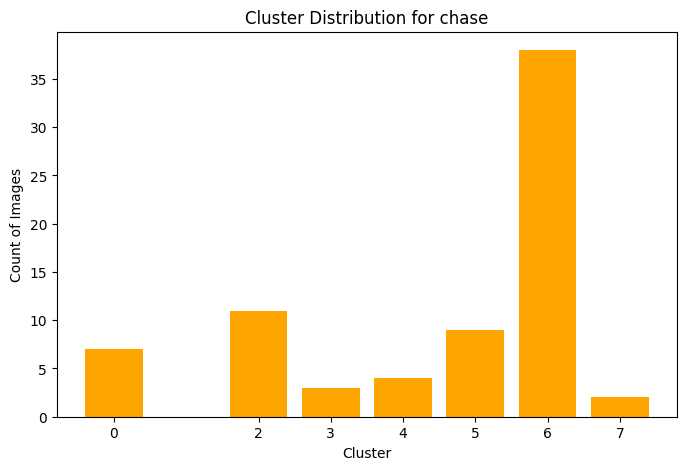

chase:  {0.0: 7, 2.0: 11, 3.0: 3, 4.0: 4, 5.0: 9, 6.0: 38, 7.0: 2}


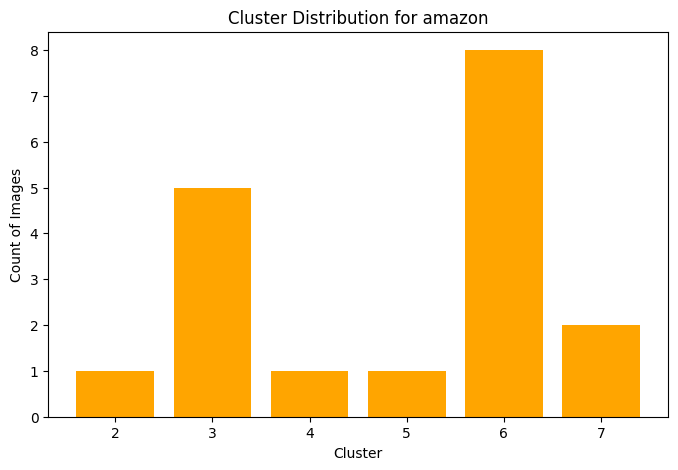

amazon:  {2.0: 1, 3.0: 5, 4.0: 1, 5.0: 1, 6.0: 8, 7.0: 2}


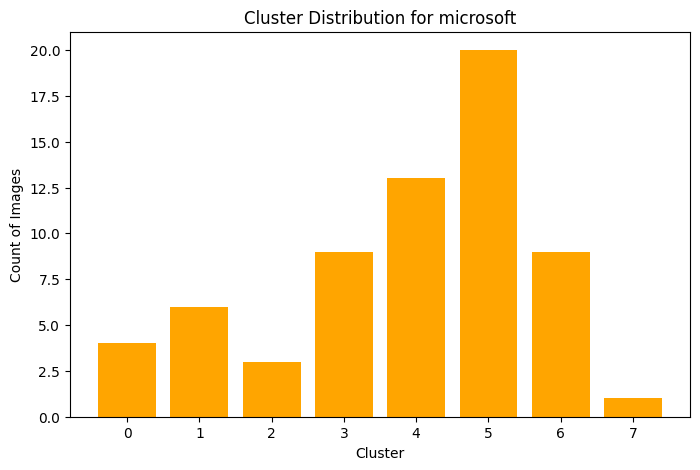

microsoft:  {0.0: 4, 1.0: 6, 2.0: 3, 3.0: 9, 4.0: 13, 5.0: 20, 6.0: 9, 7.0: 1}


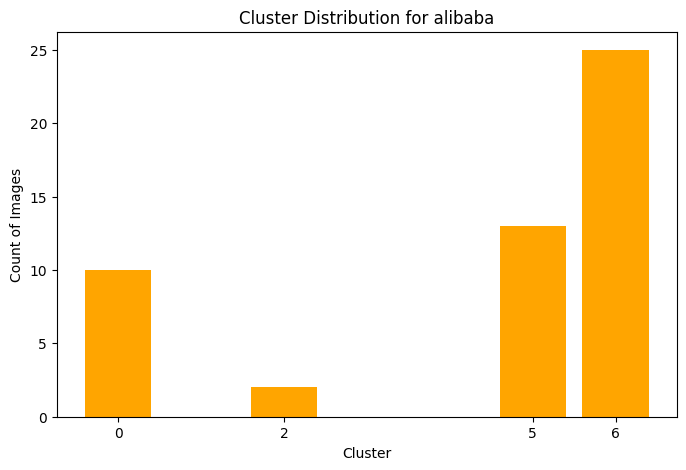

alibaba:  {0.0: 10, 2.0: 2, 5.0: 13, 6.0: 25}


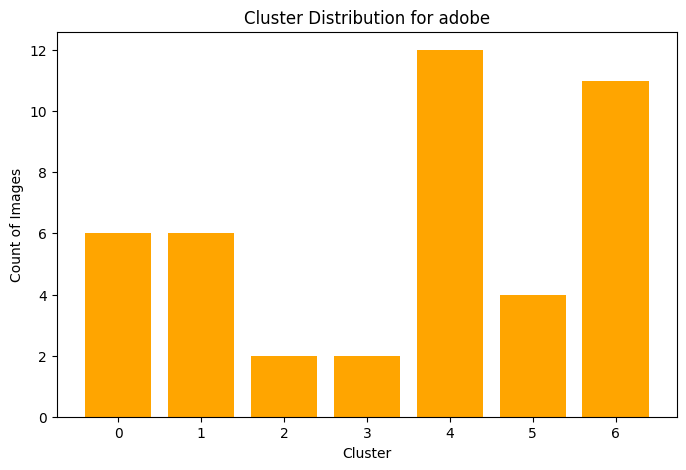

adobe:  {0.0: 6, 1.0: 6, 2.0: 2, 3.0: 2, 4.0: 12, 5.0: 4, 6.0: 11}


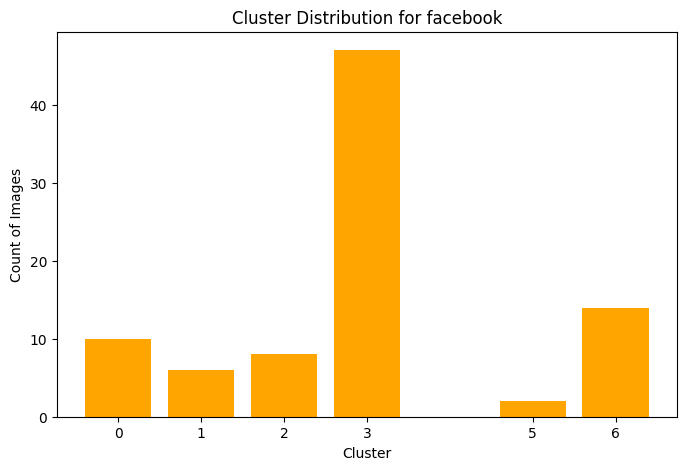

facebook:  {0.0: 10, 1.0: 6, 2.0: 8, 3.0: 47, 5.0: 2, 6.0: 14}


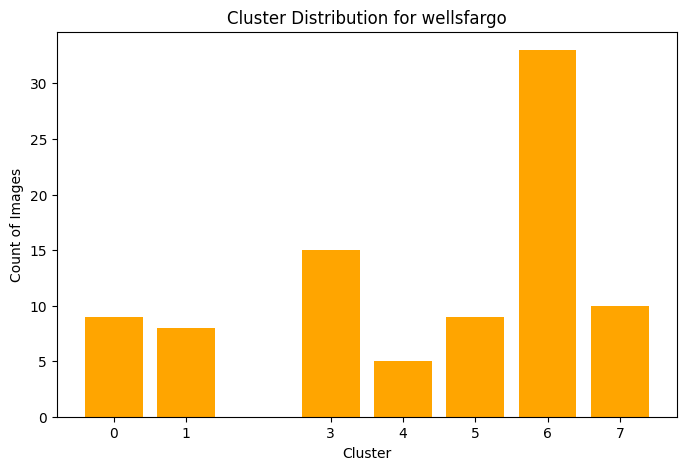

wellsfargo:  {0.0: 9, 1.0: 8, 3.0: 15, 4.0: 5, 5.0: 9, 6.0: 33, 7.0: 10}


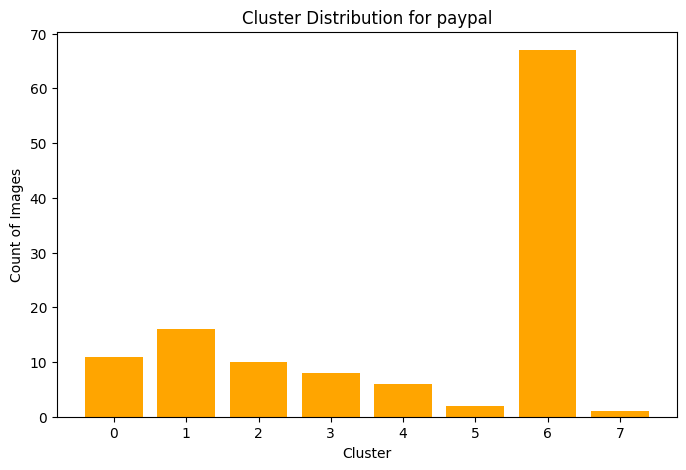

paypal:  {0.0: 11, 1.0: 16, 2.0: 10, 3.0: 8, 4.0: 6, 5.0: 2, 6.0: 67, 7.0: 1}


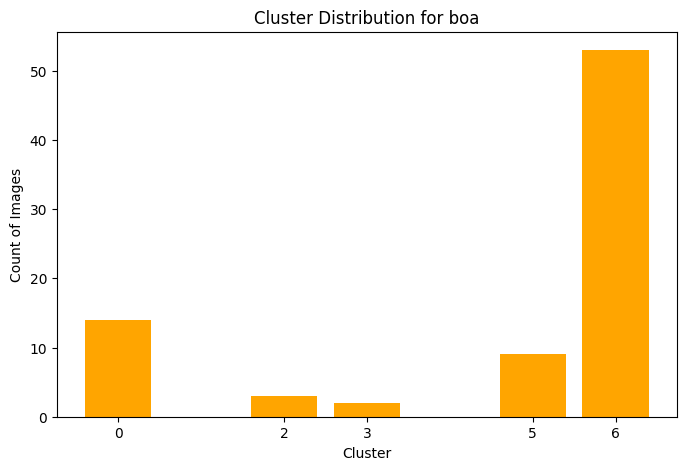

boa:  {0.0: 14, 2.0: 3, 3.0: 2, 5.0: 9, 6.0: 53}


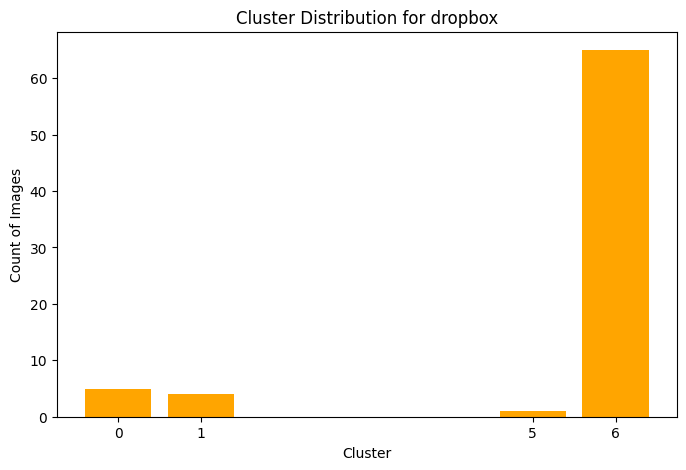

dropbox:  {0.0: 5, 1.0: 4, 5.0: 1, 6.0: 65}


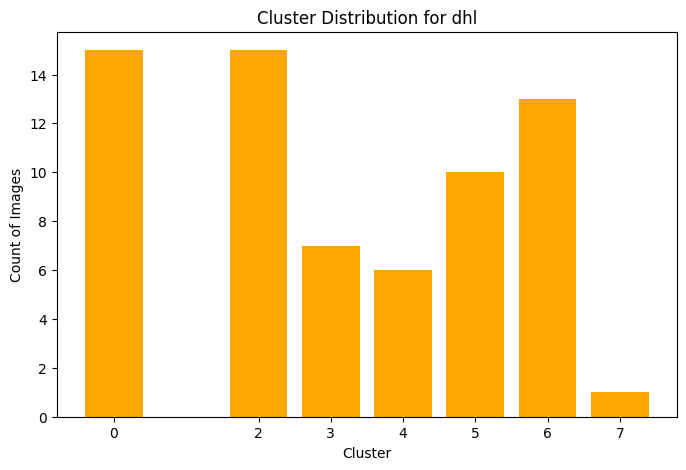

dhl:  {0.0: 15, 2.0: 15, 3.0: 7, 4.0: 6, 5.0: 10, 6.0: 13, 7.0: 1}


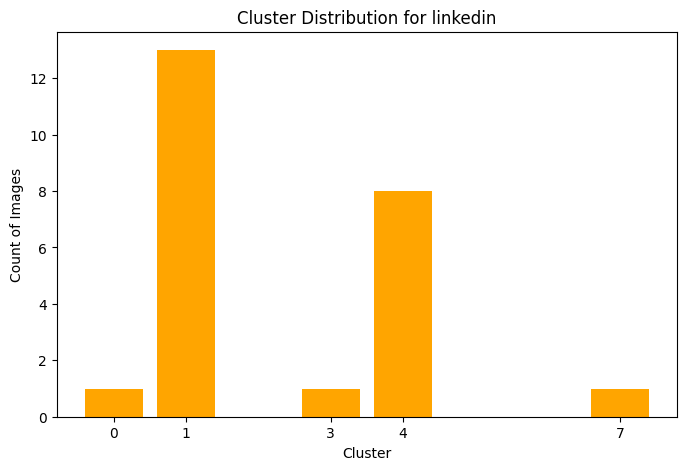

linkedin:  {0.0: 1, 1.0: 13, 3.0: 1, 4.0: 8, 7.0: 1}


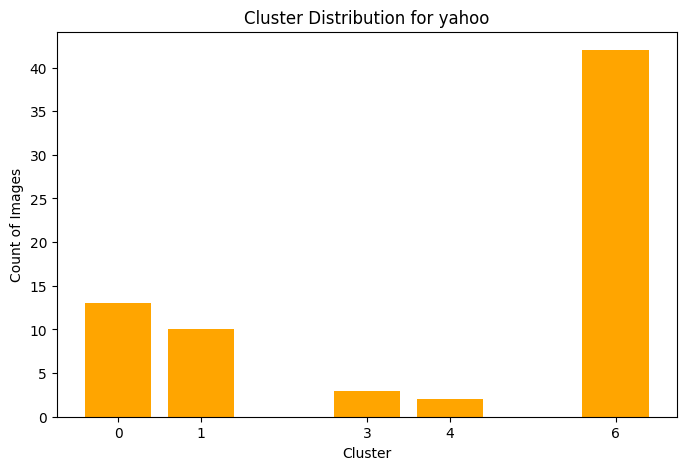

yahoo:  {0.0: 13, 1.0: 10, 3.0: 3, 4.0: 2, 6.0: 42}


In [7]:
"""
# TODO: wypisz dominujaca klase z kazdego klastra
# dict klasa -> nr klastra
# jakies metryczki z TP, TN, FP, FN i inne z scikit learna
# popraw kod xD

for company, imgs in img_per_company.items():
    predicted_class = np.zeros(shape=(len(imgs)))
    for idx, hash_of_img in enumerate(imgs):
        predicted_class[idx] = int(kmeans.predict([hasher.string_to_vector(hash_of_img)]))
    unique, counts = np.unique(predicted_class, return_counts=True)
    print(f'{company}: ', dict(zip(unique, counts)))
    print('='*10)
    
"""
for company, imgs in img_per_company.items():
    predicted_class = np.zeros(shape=(len(imgs)))
    for idx, hash_of_img in enumerate(imgs):
        predicted_class[idx] = int(
            kmeans.predict([hasher.string_to_vector(hash_of_img)])[0]
        )

    # Get the unique classes and their counts
    unique, counts = np.unique(predicted_class, return_counts=True)

    # Create a bar plot for this company
    plt.figure(figsize=(8, 5))
    plt.bar(unique, counts, color="orange")
    plt.xlabel("Cluster")
    plt.ylabel("Count of Images")
    plt.title(f"Cluster Distribution for {company}")
    plt.xticks(unique)
    plt.show()

    print(f"{company}: ", dict(zip(unique, counts)))
    print("=" * 10)